# Fig08_Draft-CCS
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 19.12.2019
    Date last modified: 19.12.2019

    ##############################################################
    Purpos:

    1) Reads in mean vertical velocities that were preprocessed in:
        

    2) plot the mean up/downdraft velocity difference dependent on dx and height
    

In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
# import shapely.geometry
# import descartes
import shapefile
import math
from scipy.stats.kde import gaussian_kde
from math import radians, cos, sin, asin, sqrt
from scipy import spatial
import matplotlib.path as mplPath
from pylab import *
from scipy.optimize import curve_fit
import scipy
import math
import SkewT
from scipy.interpolate import interp1d
# from astropy.io import ascii

### Load the data for the plot

In [2]:
rgsSimulations=['19_2011-07-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
                '23_2007-06-19_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
                '10_2009-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '13_2003-08-30_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '17_2011-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '18_2010-06-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '38_2007-08-04_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '46_2009-06-14_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '07_2011-07-04_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',

                '64_2012-06-17_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '58_2009-06-08_PGW_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
                '41_2005-06-10_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '68_2013-07-07_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '31_2006-08-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '16_2002-06-11_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '34_2010-07-12_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '51_2003-06-23_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '56_2008-06-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '35_2004-07-02_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5']

rgrGridSpacing=['12000','12000nc','4000','2000','1000','500','250']
rgrDX=[12000,12000,4000,2000,1000,500,250]
sSimDir='/glade/p/mmm/c3we/Idealized_MCSs/data/WRF/'

iEvents=10 # number of events that will be considered

sPlotDir='/glade/u/home/prein/papers/Idealized-MCSs/plots/Fig08_Draft-CCS/'

rgiDomSize=[51,51,155,311,623,1247,2495]
iOutInt=12 # slizes per hour
ihours=7 # runtime in hours
iSkipH=3 # hours that should be excluded from the simulation
iRadPmax=60000. # m
iRadVol=100000. # m for the volume calculation

sGrid='12km'
rgsStats=['Upward Massflux Diff.', 'Downward Massflux Diff.']
Stat='MEAN'
rgrMassFLX=np.zeros((2,len(rgsSimulations),len(rgrGridSpacing),5,95)); rgrMassFLX[:]=np.nan
MassFluxAll=np.zeros((2,len(rgsSimulations),len(rgrGridSpacing),95,50)); MassFluxAll[:]=np.nan
for si in range(len(rgsSimulations)):
    print '    Load '+rgsSimulations[si]
    grDATA={}
    for dx in range(len(rgrGridSpacing)):
        try:
            fname='/glade/scratch/prein/Papers/Idealized_MCSs/data/MCS-VertMassFlux/'+sGrid+'/'+rgsSimulations[si]+'_'+rgrGridSpacing[dx]+'m_Smooth-36000_'+sGrid+'-grid'+Stat+'.pkl'
            grDATA[rgrGridSpacing[dx]]=pickle.load( open( fname, "rb" ) )['0']
        except:
            continue
    try:
        grRef=grDATA['250']
    except:
        stop()
    for dx in range(len(rgrGridSpacing)):
        try:
            grMod=grDATA[rgrGridSpacing[dx]]
        except:
            continue

        # calculate mass flux percentiles
        rgrRef_UFLX=grRef['Upw_FLX']; rgrRef_UFLX[rgrRef_UFLX == 0]=np.nan
        rgrMod_UFLX=grMod['Upw_FLX']; rgrMod_UFLX[rgrMod_UFLX == 0]=np.nan
        rgrMassFLX[0,si,dx,:,:]=np.nanpercentile(rgrMod_UFLX, (0,25,50,75,100),axis=1)
        rgrRef_DFLX=grRef['Dnw_FLX']; rgrRef_DFLX[rgrRef_DFLX == 0]=np.nan
        rgrMod_DFLX=grMod['Dnw_FLX']; rgrMod_DFLX[rgrMod_DFLX == 0]=np.nan
        if len(rgrRef_DFLX[0,:]) != len(rgrMod_DFLX[0,:]):
            Smaller=np.min([len(rgrRef_DFLX[0,:]),len(rgrMod_DFLX[0,:])])
            rgrRef_DFLX=rgrRef_DFLX[:,:Smaller]
            rgrMod_DFLX=rgrMod_DFLX[:,:Smaller]
        rgrMassFLX[1,si,dx,:,:]=np.nanpercentile(rgrMod_DFLX, (0,25,50,75,100),axis=1)

        MassFluxAll[0,si,dx,:,:rgrMod_UFLX.shape[1]]=rgrMod_UFLX
        MassFluxAll[1,si,dx,:,:rgrMod_DFLX.shape[1]]=rgrMod_DFLX


# calculate if samples are significantly different
MannWithney_P=np.zeros((2,len(rgrGridSpacing),95)); MannWithney_P[:]=np.nan
for dx in range(len(rgrGridSpacing)):
    for hh in range(95):
        Current=np.nanmean(MassFluxAll[0,:10,dx,hh,:], axis=1); Current=Current[~np.isnan(Current)]
        Future=np.nanmean(MassFluxAll[0,-10:,dx,hh,:], axis=1); Future=Future[~np.isnan(Future)]
        Min=np.min([len(Current),len(Future)])
        MannWithney_P[0,dx,hh]=scipy.stats.wilcoxon(Current[:Min],Future[:Min])[1]
        Current=np.nanmean(MassFluxAll[1,:10,dx,hh,:], axis=1); Current=Current[~np.isnan(Current)]
        Future=np.nanmean(MassFluxAll[1,-10:,dx,hh,:], axis=1); Future=Future[~np.isnan(Future)]
        Min=np.min([len(Current),len(Future)])
        MannWithney_P[1,dx,hh]=scipy.stats.wilcoxon(Current[:Min],Future[:Min])[1]


    Load 19_2011-07-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 23_2007-06-19_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5


/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1172: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


    Load 10_2009-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 13_2003-08-30_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 17_2011-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 18_2010-06-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 38_2007-08-04_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 46_2009-06-14_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 07_2011-07-04_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 64_2012-06-17_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 58_2009-06-08_PGW_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 41_2005-06-10_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 68_2013-07-07_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 31_2006-08-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 16_2002-06-11_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 34_2010-07-12_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 51_2003-06-23_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 56_2008-06-18_PGW_Midwes

/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: Mean of empty slice
/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice
/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/scipy/stats/morestats.py:2385: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: Mean of empty slice
/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: Mean of empty slice


### Plotting

        Plot map to: /glade/u/home/prein/papers/Idealized-MCSs/plots/Fig08_Draft-CCS/Fig08_Draft-CCS.pdf


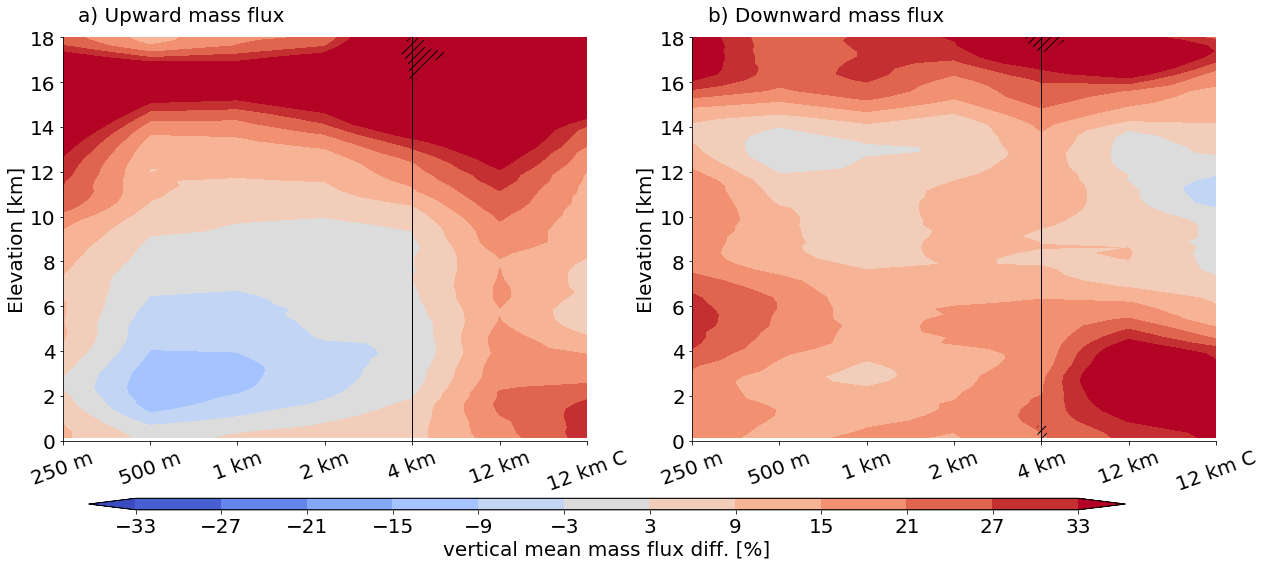

In [11]:
# set the font size
plt.rcParams.update({'font.size': 15})
rgsLableABC=list(string.ascii_lowercase)

fig = plt.figure(figsize=(18,8))
plt.rcParams.update({'font.size': 20})

gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.08, right=0.97,
           bottom=0.20, top=0.9,
           wspace=0.20, hspace=0.25)

rgsColors=['k','#e31a1c']
rgsPeriods=['Upward','Downward']
for tp in range(2):
    if tp == 0:
        Period='Upward mass flux'
#         DATA=((np.nanmean(rgrMassFLX[0,-10:,:,2,:], axis=(0))-np.nanmean(rgrMassFLX[0,:10,:,2,:], axis=(0)))/np.nanmean(rgrMassFLX[0,:10,:,2,:], axis=(0)))*100.
        DATA=((np.nanmean(MassFluxAll[0,-10:,:,:], axis=(0,3))-np.nanmean(MassFluxAll[0,:10,:,:], axis=(0,3)))/np.nanmean(MassFluxAll[0,:10,:,:], axis=(0,3)))*100.
    else:
        Period='Downward mass flux'
#         DATA=((np.nanmean(rgrMassFLX[1,-10:,:,2,:], axis=(0))-np.nanmean(rgrMassFLX[1,:10,:,2,:], axis=(0)))/np.nanmean(rgrMassFLX[1,:10,:,2,:], axis=(0)))*100.
        DATA=((np.nanmean(MassFluxAll[1,-10:,:,:], axis=(0,3))-np.nanmean(MassFluxAll[1,:10,:,:], axis=(0,3)))/np.nanmean(MassFluxAll[1,:10,:,:], axis=(0,3)))*100.
    st=0
    ax = plt.subplot(gs1[0,tp])

    PlotData=np.transpose(DATA)#; PlotData[np.isnan(PlotData)]=0
    Levels=np.linspace(-33,33,12)
    cs=plt.contourf(range(7)[::-1], np.array(grRef['levels'])/1000., PlotData, levels=Levels, extend='both', cmap='coolwarm')
    csH=plt.contourf(range(7)[::-1], np.array(grRef['levels'])/1000., np.transpose(MannWithney_P[tp,:,:]), 
                     levels=[0,0.1,1],hatches=['///',None], facecolor="none",fill=False, colors='none')

    xx = range(7) #[0.5,1.5, 2.5, 3.5,4.5,5.5,6.5]
    labels = [ '12 km C',  '12 km',  '4 km', '2 km','1 km','500 m', '250 m']
    plt.xticks(xx, labels[::-1], rotation=20)
    ax.set_ylabel('Elevation [km]')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(0, 6)
    plt.axhline(y=0, c='k', lw=0.5)
    plt.ylim(0,18)
    ax.axvline(x=4, ls='-', c='k', zorder=10, alpha=1, lw=1)

    ax.text(0.03,1.03, rgsLableABC[tp]+') '+Period, ha='left',va='bottom', \
            transform = ax.transAxes, fontname="Times New Roman Bold") #, fontsize=17)
    # add colorbar
    CbarAx = axes([0.10,0.08, 0.8, 0.02])
    cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both', label='vertical mean mass flux diff. [%]', ticks=Levels)
    
# Plot the figure
sPlotFile=sPlotDir
sPlotName= 'Fig08_Draft-CCS.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print '        Plot map to: '+sPlotFile+sPlotName
fig.savefig(sPlotFile+sPlotName)